<a href="https://colab.research.google.com/github/SrinivasPaiM/major-project-1/blob/main/Arrhythmia_Classification_Full_and_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Single-Lead ECG Arrhythmia Classification**




## **Information about Dataset:**


The dataset can be downloaded from the original [website](https://physionet.org/content/mitdb/1.0.0/) or by clicking the [link](https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip) directly. The overall information about the dataset is given [here](https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm).
1. The MIT-BIH dataset contains **48 readings**.
2. Number of **patients = 47** (25 Men, 22 Women). Only 1 patient has 2 readings. Rest 1 readings/patients.
3. Each reading contains a. ECG signals b. Annotations
4. ECG signals length = **30 Minutes** (or slightly over). Sampling Frequency = **360 Hz**.
5. Each reading contains **2 Lead ECG** signals that are Modified Limb Lead II and Modified Lead V1 (Occationally V2, V5, V4 just only once). Simply, Two Leads: **MLII, V1**.
6. Annotation is given for each beat. Although 20 types of beats are annotated in dataset. We consider only **15 types** of beats grouped in **5 classes** followed by the recommendation of **AAMI**.
* N - Normal
* S - Supraventricular premature beat
* V - Premature ventricular contraction
* F - Fusion of ventricular and normal beat
* Q - Unclassifiable / Unknown beat

### **Additional Dataset Information:**
The source of the ECGs included in the MIT-BIH Arrhythmia Database is a set of over **4000 long-term Holter recordings** that were obtained by the **Beth Israel Hospital** Arrhythmia Laboratory between **1975 and 1979**. Approximately **60%** of these recordings were obtained from **inpatients**. The subjects were 25 men aged 32 to 89 years, and 22 women aged 23 to 89 years

# **Main Parts of the Study:**

1.   **Part A: Installing Packages and Basic Visualization of ECG**
2.   **Part B: Denoising, R-Peak Detection, Segmentation**
3.   **Part C: Dataset Loading**
4.   **Part D: Train-Test Splitting and Class Balancing**
5.   **Part E: Model Building and Training**
6.   **Part F: Results**

# **Part A: Installing Packages and Basic Visualization of ECG**

## **A1: Installing Packages**

In [ ]:
# wfdb is not normally installed in Colab
%pip install wfdb

In [ ]:
%pip install seaborn


In [ ]:
%pip install tensorflow

In [ ]:
%pip install sklearn


In [2]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [3]:
project_path = r"C:\Desktop Folders\af\mit-bih-arrhythmia-database-1.0.0"

## **A2: Basic Visualization of ECG**
Basic code for loading (reading), plotting and playing with ECG signals

### **a. Getting Recordings' IDs**
The ECG recordings are named after Patients' IDs (from 100 to 234), sorted but not consecutive. Total 48 recordings.

In [4]:
# The ECG recordings are named after Patients' IDs (from 100 to 234), sorted but not consecutive. Total 48 recordings.
# Assuming the patient IDs are listed in a file named 'RECORDS' within the project_path
records_file = os.path.join(project_path, 'RECORDS')
patient_ids = pd.read_csv(records_file, header=None).to_numpy().reshape(-1)
patient_ids

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234])

### **b. 1 Patient ECG loading and plotting**
Extracting 2 leads ECG signals of a patient (for example: 100), and saving in two lists.

In [5]:
#Extracting just 1 patient ECG signal and info
lead0 = {}  # without this it shows lead0[100] is not defined
lead1 = {}
patient_id = 100
signals, info = wfdb.io.rdsamp(osj(project_path, str(100)))
lead0[100] = signals[:, 0]
lead1[100] = signals[:, 1]

<class 'numpy.ndarray'>
(650000,)
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


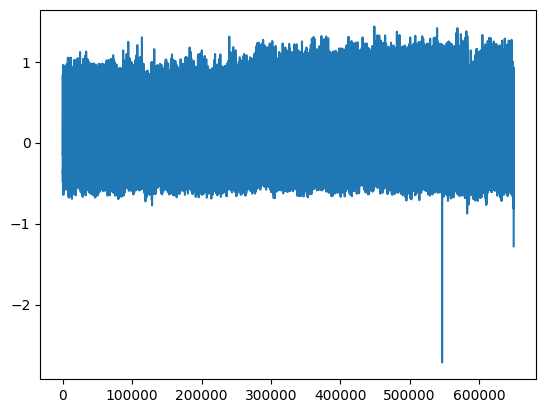

In [6]:
# Visualization of 1 patients signal and info
print(type(lead0[100]))
print(lead0[100].shape)
plt.plot(lead0[100])
print(info)

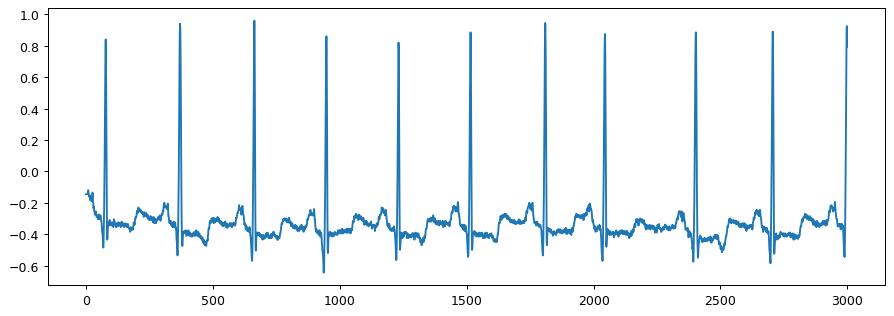

In [7]:
# ECG signal per second
a = lead0[100][0: 3000]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)

### **c. All patients' ECG loading**

In [8]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(project_path, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [9]:
# Loading all patient ECG INFORMATION
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(project_path, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [10]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

Text(0, 0.5, 'Amplitude (mV)')

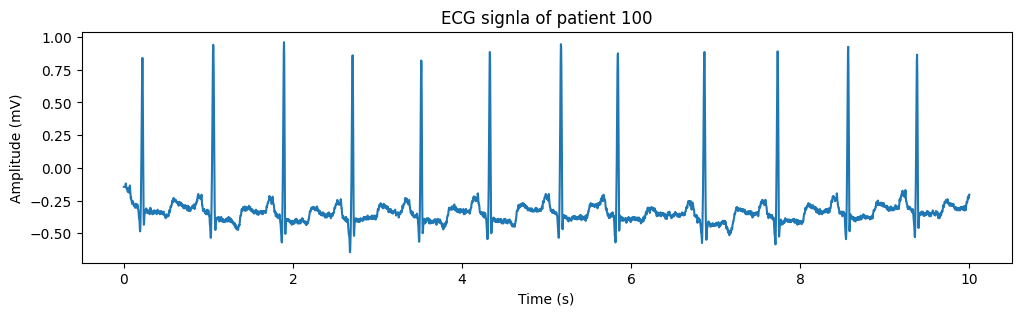

In [11]:
# Plot any patient signal from any time frame
patient_id = 100 # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*350
ending_signal_point = ending_time*350 # As sampling frequency is 350 Hz
x = np.arange(starting_time, ending_time, 1/350)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x, signal)
plt.title(f'ECG signla of patient {patient_id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

In [12]:
# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

# **Part B: Denoising, R-Peak Detection, Segmentation**

### **B1: Denoising**
Noise removing by using Discrete Wavelet Transform (DCT)

In [13]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

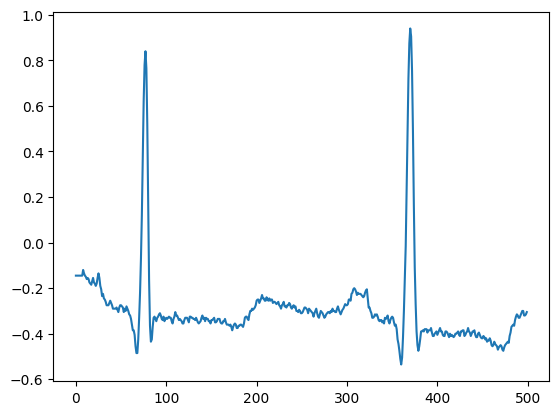

In [14]:
# Ploting a signal before denoising
record = wfdb.rdrecord(project_path + '/100', channel_names=['MLII'])
data = record.p_signal.flatten()
plt.plot(data[0:500])

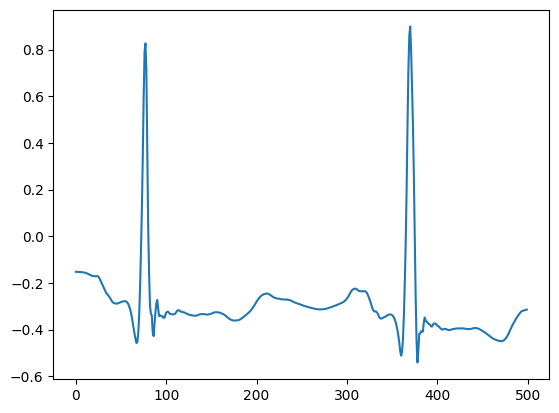

In [15]:
# Same signal after denoising
rdata = denoise(data=data)
plt.plot(rdata[0:500])

### **B2: R-Peak Detection**
R-peak is annotated in MIT-BIH dataset. Just need to read the file.

In [16]:
# For exmaple, we extract '100' recording annotation
annotation = wfdb.rdann(project_path + '/100', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
print(Rclass)

[    18     77    370 ... 649484 649734 649991]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

In [17]:
len(annotation.symbol)

2274

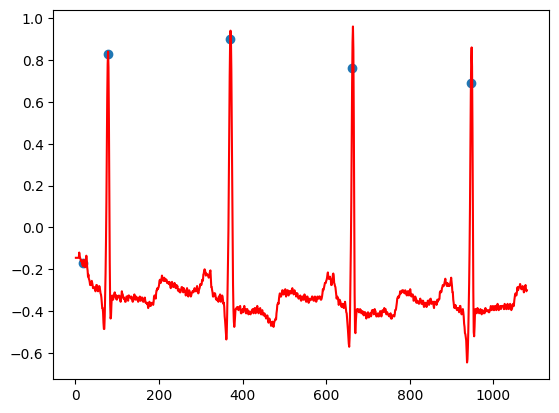

In [18]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

### **B3: Segmentation**
Each ECG signal is segmented by using a window **length of 300**. From R-peak location, **99** samples taken from **left** and **201** samples from **right**. Thus a complete **heartbeat** is found.

(300,)
(300,)
(300,)


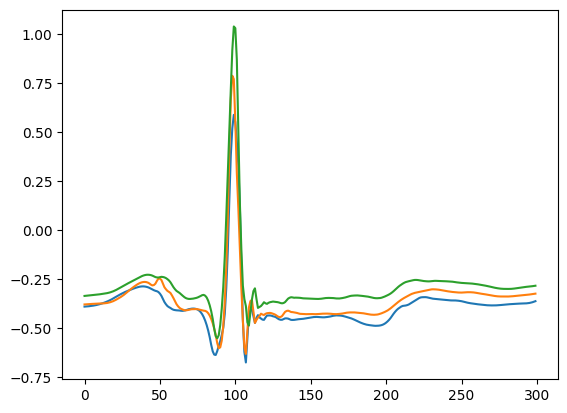

In [19]:
# Plotting 3 heartbeats
k = np.arange(100, 103)
for i in k:
  # print(i)
  # print(Rlocation[i] - 99, Rlocation[i] + 201)
  x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
  plt.plot(x_train)
  print(x_train.shape)
plt.show()

### **B4: Complete Preprocessing Figures**
The complete preprocessing including denosinsing, R-peak location detection and segmentation is expected to view in a single figure.

In [20]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

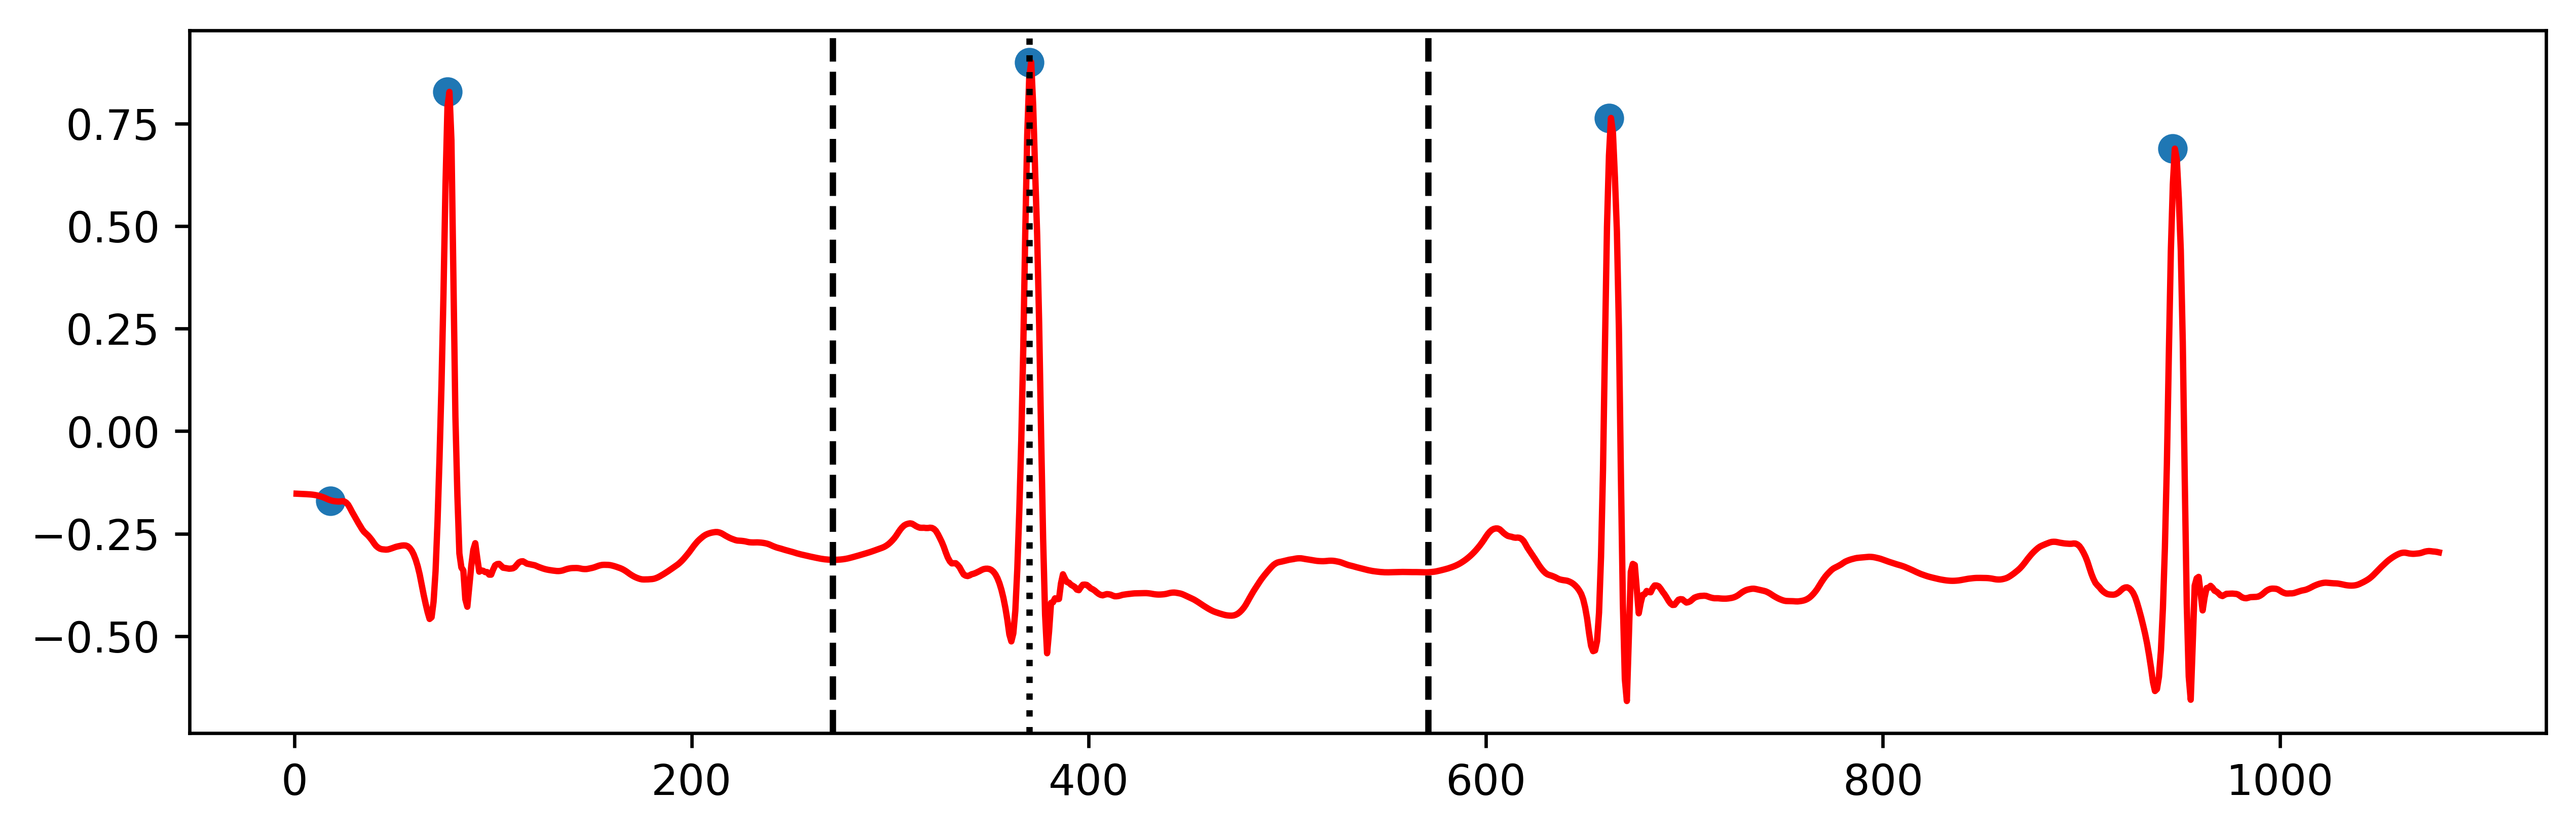

In [21]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':')
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

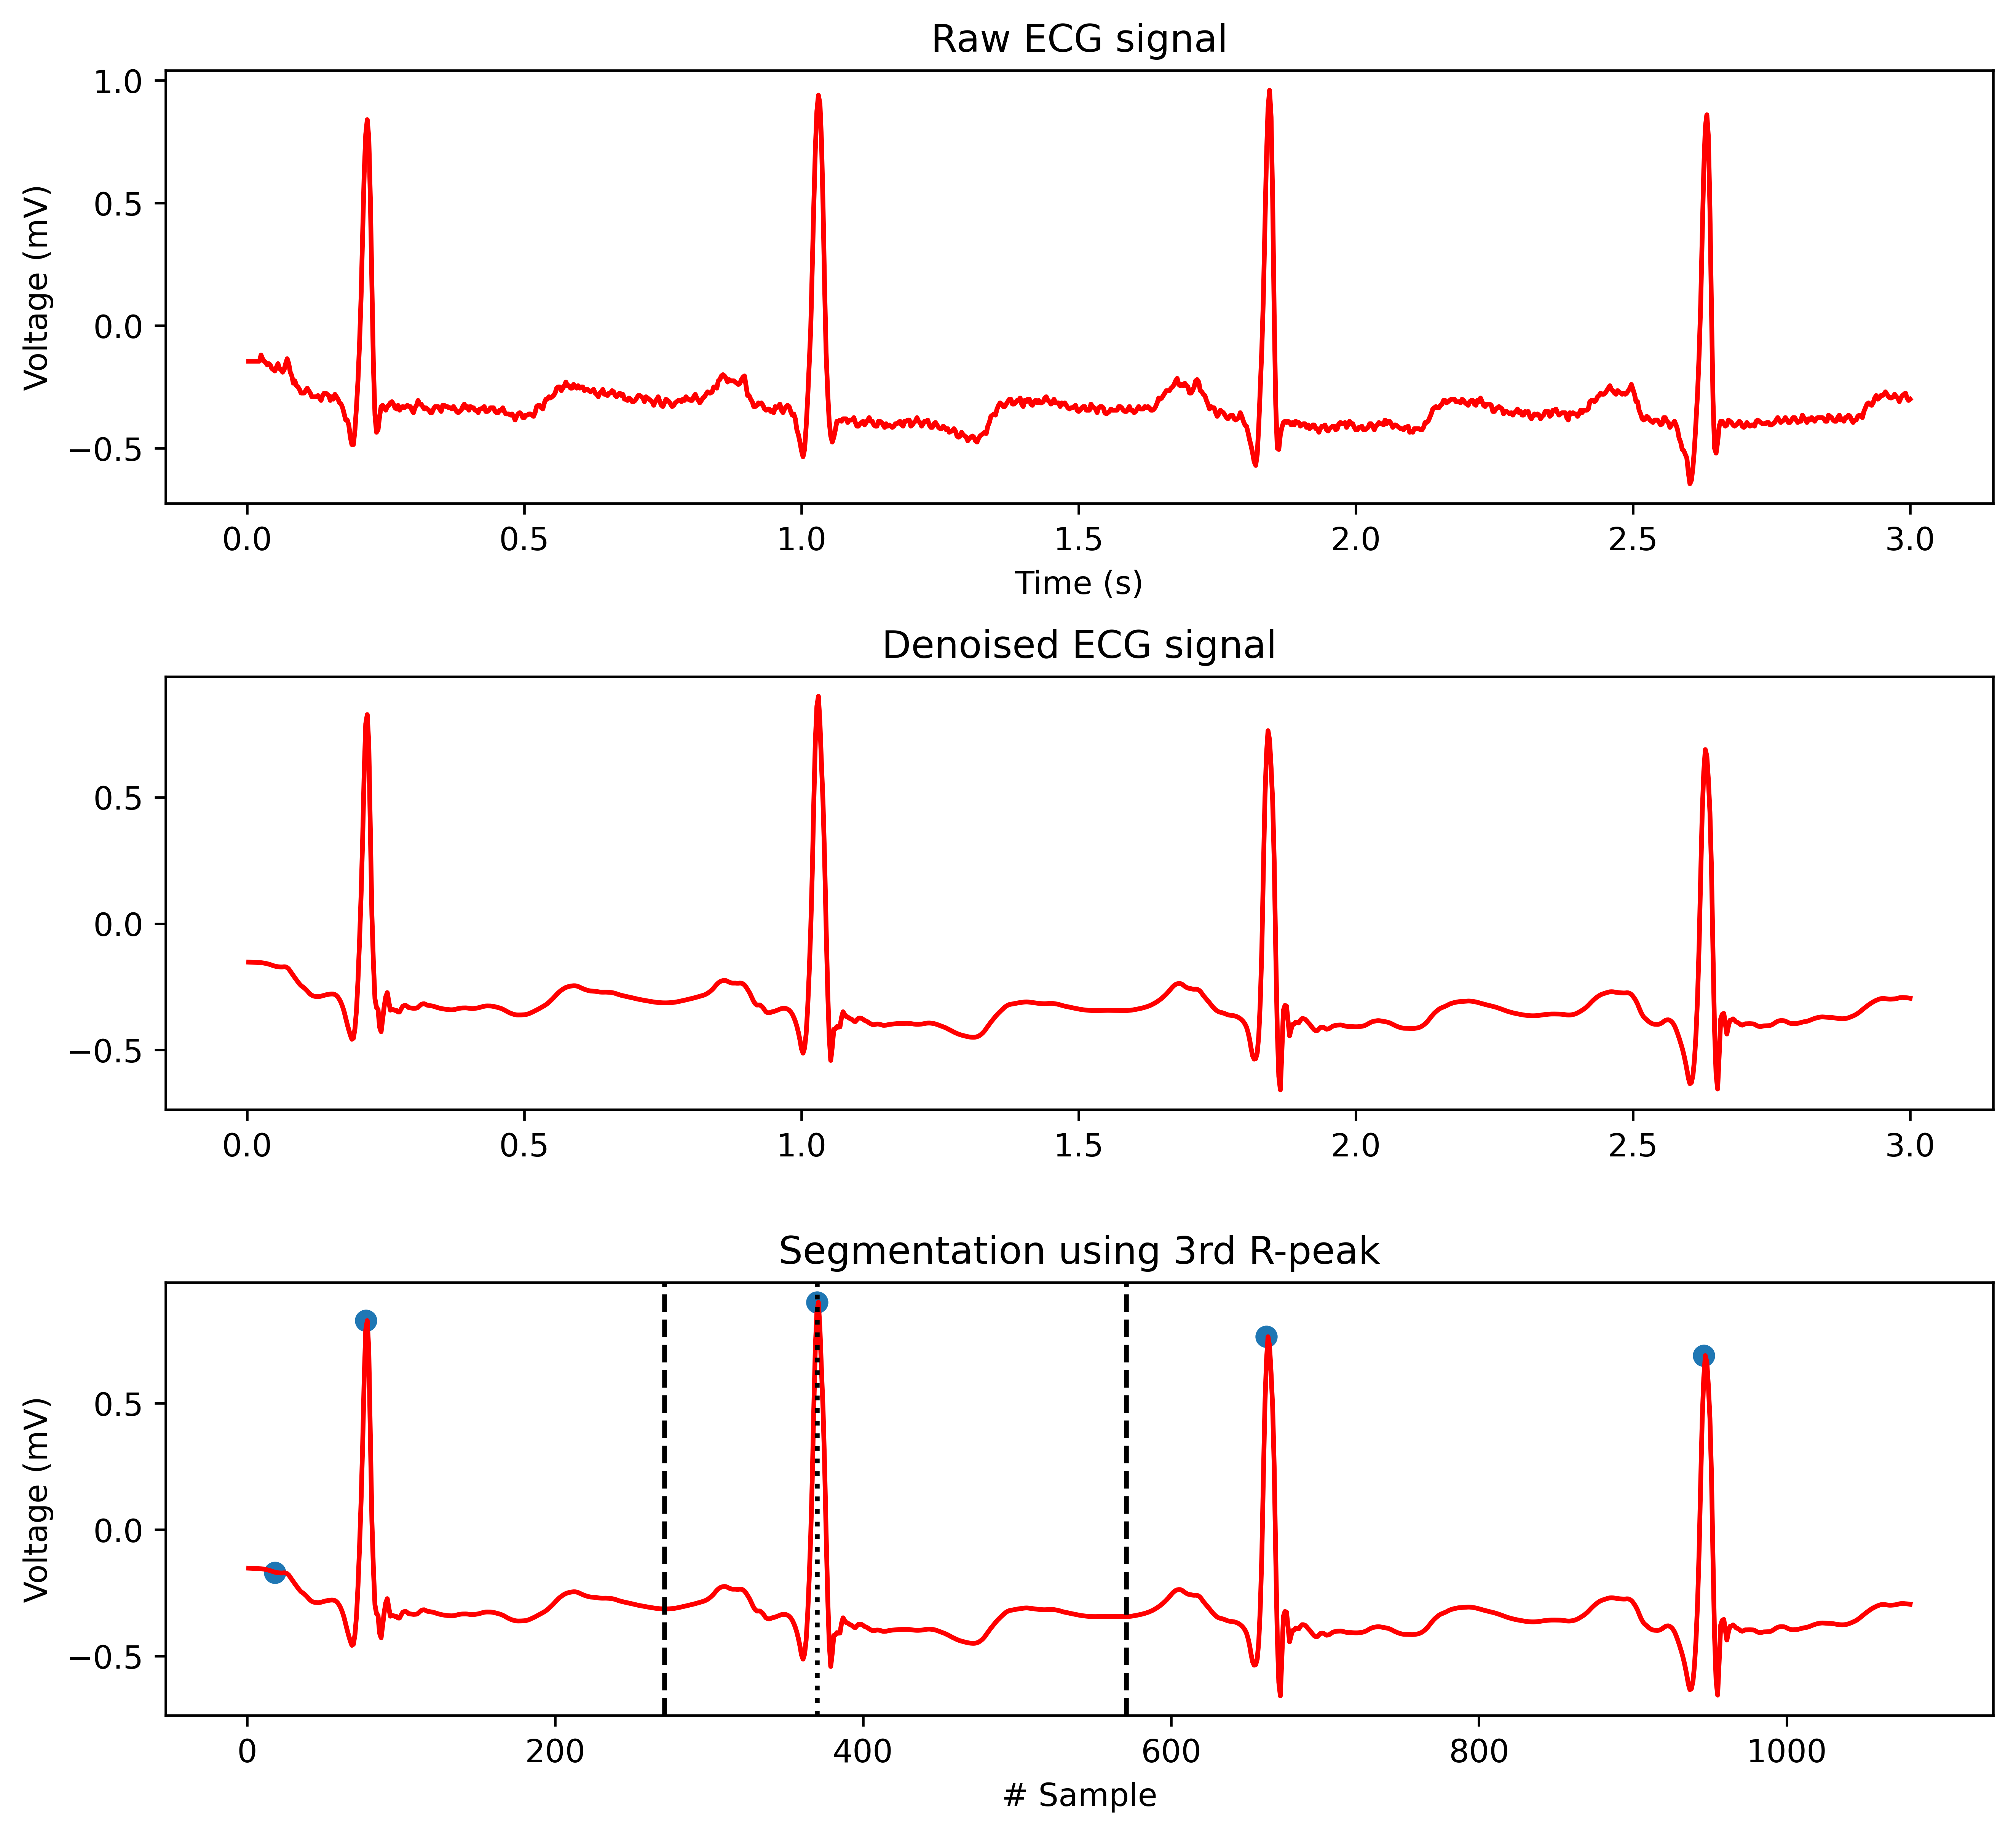

In [22]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/360, rdata[0:1080], color='red')
plt.title('Denoised ECG signal')

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
# Create the directory if it doesn't exist
os.makedirs(figure_path, exist_ok=True)
fig.savefig(figure_path+ 'Denoised and segmented ECG.png')

# **Part C: Dataset Loading**

## **C1: Loading whole data**

In [23]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    print("reading " + number+ " ECG data...")
    record_path = os.path.join(project_path, number)
    _, info = wfdb.io.rdsamp(record_path)
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(f'Channels: {channel1}, {channel2}')


    # Read ECG data records
    record = wfdb.rdrecord(record_path, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(record_path, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [24]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [25]:
# Input X and Output Y data loading
X, Y = loadData()

reading 100 ECG data...
Channels: MLII, V5
reading 101 ECG data...
Channels: MLII, V1
reading 102 ECG data...
Channels: V5, V2
reading 103 ECG data...
Channels: MLII, V2
reading 104 ECG data...
Channels: V5, V2
reading 105 ECG data...
Channels: MLII, V1
reading 106 ECG data...
Channels: MLII, V1
reading 107 ECG data...
Channels: MLII, V1
reading 108 ECG data...
Channels: MLII, V1
reading 109 ECG data...
Channels: MLII, V1
reading 111 ECG data...
Channels: MLII, V1
reading 112 ECG data...
Channels: MLII, V1
reading 113 ECG data...
Channels: MLII, V1
reading 114 ECG data...
Channels: V5, MLII
reading 115 ECG data...
Channels: MLII, V1
reading 116 ECG data...
Channels: MLII, V1
reading 117 ECG data...
Channels: MLII, V2
reading 118 ECG data...
Channels: MLII, V1
reading 119 ECG data...
Channels: MLII, V1
reading 121 ECG data...
Channels: MLII, V1
reading 122 ECG data...
Channels: MLII, V1
reading 123 ECG data...
Channels: MLII, V5
reading 124 ECG data...
Channels: MLII, V4
reading 200 ECG

In [26]:
%pip install collection

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# Counting the number of each type of heartbeats
from collections import Counter
Y_list = list(Y)
Counter(Y_list)

Counter({np.float64(0.0): 74920,
         np.float64(1.0): 8063,
         np.float64(2.0): 7244,
         np.float64(9.0): 7123,
         np.float64(12.0): 7012,
         np.float64(5.0): 2540,
         np.float64(13.0): 982,
         np.float64(11.0): 802,
         np.float64(4.0): 229,
         np.float64(6.0): 150,
         np.float64(10.0): 106,
         np.float64(7.0): 83,
         np.float64(14.0): 33,
         np.float64(3.0): 16,
         np.float64(8.0): 2})

## **C2: Ploting 15 Different Heartbeats**

In [28]:
# making pandas dataframe
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)

In [29]:
# changing the name from 0 to 300
df_Y.rename(columns = {0:300}, inplace = True)
# join X and Y
df = pd.concat([df_X, df_Y], axis=1)

In [30]:
def Plot_Random_Beat(type, num):

  ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'slash', 'f', 'Q']

  ecgClassName = ['Normal (N)', 'Left bundle br. bl. (L)', 'Right bundle br. bl. (R)',
                  'Atrial escape (e)', 'Nodal jun. esc. (j)', 'Atrial premature (A)',
                  'Aberrated atrial prem. (a)', 'Nodal jun. pre. (J)',
                  'Supraventricular prem. (S)', 'Premature ventr. (V)',
                  'Ventricular escape (E)', 'Fusion of ve. & no. (F)',
                  'Paced (/)', 'Fusion of pa. & no. (f)',
                  'Unclassifiable(Q)']

  # getting only a specific class ECG signal
  df_0 = df.loc[df[300]==type]  # For normanl class: 0, shape is 74920,301
  df_0 = df_0.drop(columns=[300]) # changing the shape to 74920,300

  # selecting some random row to plot
  if num<=df_0.shape[0]:
    np.random.seed(234)
    random_beat_number = np.random.randint(df_0.shape[0], size=(num))
    random_beat_number = list(random_beat_number)
  else: # Needed for Supraventricular Premature Beat (S) only, as it contains only 2 beats
    print(f"Warning: You have only {df_0.shape[0]} beat, but asked to plot {num}")
    random_beat_number = np.arange(0, df_0.shape[0])
    random_beat_number = list(random_beat_number)

  # ploting the ECG signal
  for i in random_beat_number:
    ecg_beat = df_0.iloc[i]
    plt.plot(ecg_beat)
  plt.title(str(ecgClassName[type]))

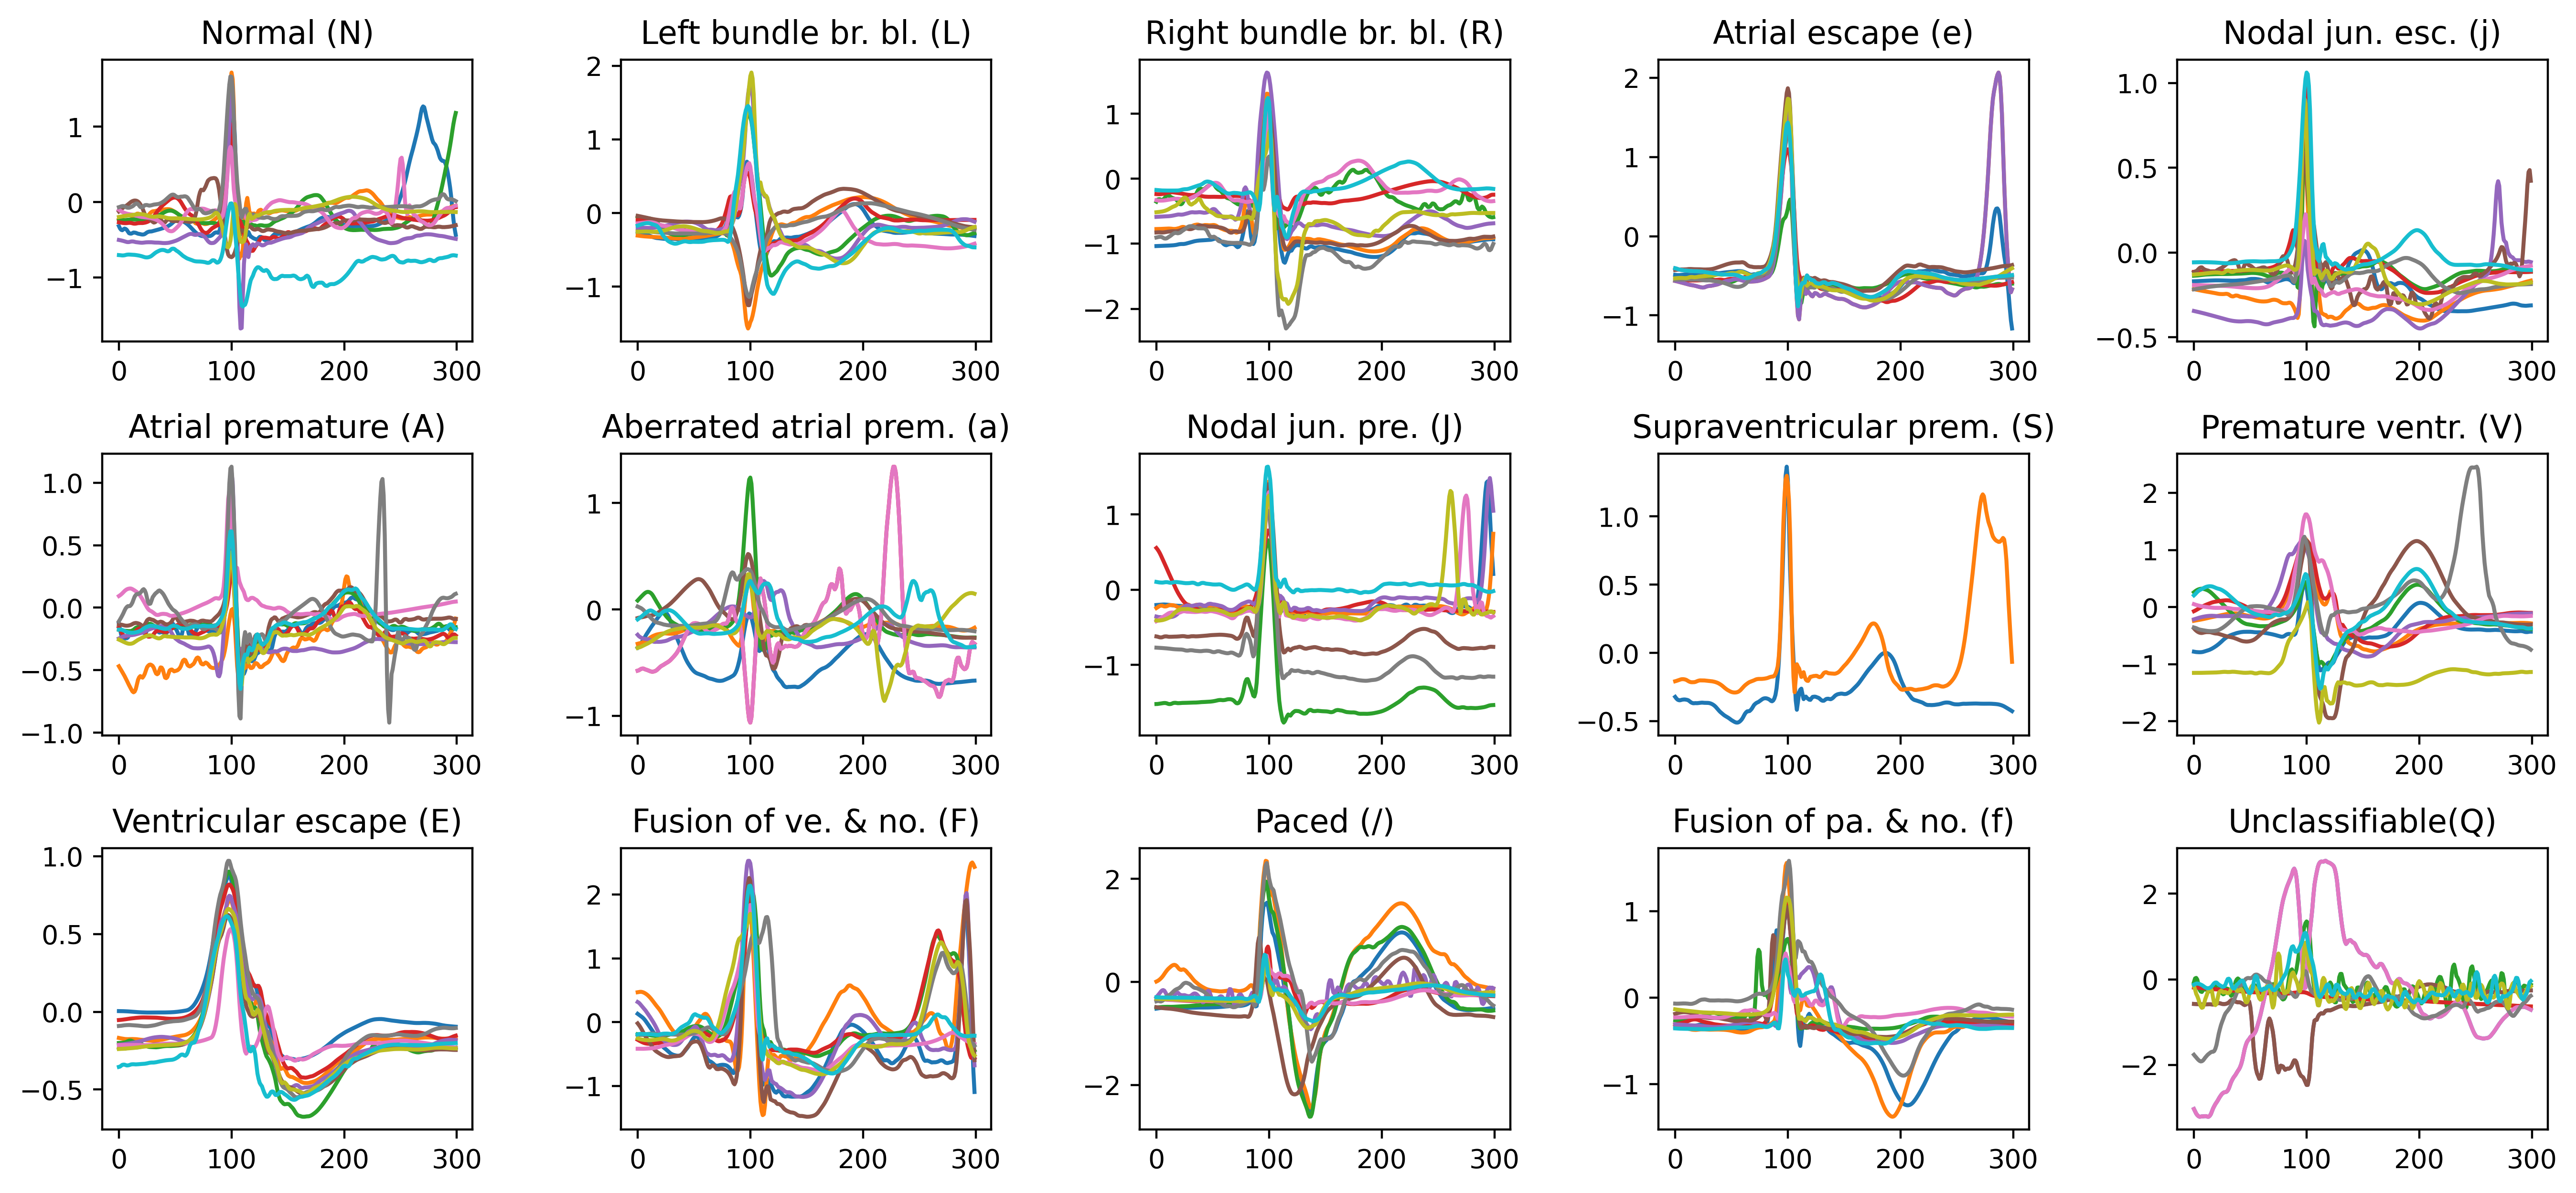

In [31]:
# Plotting 15 different types of heartbeat
fig = plt.figure(figsize=(16,7), dpi=400)
fig.tight_layout(pad=15.0)
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  Plot_Random_Beat(type=i, num=10)
figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
fig.savefig(figure_path+ 'all_heartbeats.png')

# **Part D: Train-Test Splitting and Class Balancing**

## **D1: Data loading**
Data is already loaded, **this step can be skipped.** However, here the whole dataset is saved in a train_ds variable.

### **a. Load whole data**

In [32]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [33]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300
# and 301 colum is its label among 15 difference level
train_ds = loadData()

reading 100 ECG data...
Channels: MLII, V5
reading 101 ECG data...
Channels: MLII, V1
reading 102 ECG data...
Channels: V5, V2
reading 103 ECG data...
Channels: MLII, V2
reading 104 ECG data...
Channels: V5, V2
reading 105 ECG data...
Channels: MLII, V1
reading 106 ECG data...
Channels: MLII, V1
reading 107 ECG data...
Channels: MLII, V1
reading 108 ECG data...
Channels: MLII, V1
reading 109 ECG data...
Channels: MLII, V1


reading 111 ECG data...
Channels: MLII, V1
reading 112 ECG data...
Channels: MLII, V1
reading 113 ECG data...
Channels: MLII, V1
reading 114 ECG data...
Channels: V5, MLII
reading 115 ECG data...
Channels: MLII, V1
reading 116 ECG data...
Channels: MLII, V1
reading 117 ECG data...
Channels: MLII, V2
reading 118 ECG data...
Channels: MLII, V1
reading 119 ECG data...
Channels: MLII, V1
reading 121 ECG data...
Channels: MLII, V1
reading 122 ECG data...
Channels: MLII, V1
reading 123 ECG data...
Channels: MLII, V5
reading 124 ECG data...
Channels: MLII, V4
reading 200 ECG data...
Channels: MLII, V1
reading 201 ECG data...
Channels: MLII, V1
reading 202 ECG data...
Channels: MLII, V1
reading 203 ECG data...
Channels: MLII, V1
reading 205 ECG data...
Channels: MLII, V1
reading 207 ECG data...
Channels: MLII, V1
reading 208 ECG data...
Channels: MLII, V1
reading 209 ECG data...
Channels: MLII, V1
reading 210 ECG data...
Channels: MLII, V1
reading 212 ECG data...
Channels: MLII, V1
reading 213

In [34]:
Y = train_ds[:, 300]

In [35]:
# Here 15 class of ECG data are saved
Y_list = list(Y)
Counter(Y_list)

Counter({np.float64(0.0): 74920,
         np.float64(1.0): 8063,
         np.float64(2.0): 7244,
         np.float64(9.0): 7123,
         np.float64(12.0): 7012,
         np.float64(5.0): 2540,
         np.float64(13.0): 982,
         np.float64(11.0): 802,
         np.float64(4.0): 229,
         np.float64(6.0): 150,
         np.float64(10.0): 106,
         np.float64(7.0): 83,
         np.float64(14.0): 33,
         np.float64(3.0): 16,
         np.float64(8.0): 2})

### **b. 15 types to 5 level conversion**

In [36]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [37]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({np.float64(0.0): 90472,
         np.float64(4.0): 8027,
         np.float64(2.0): 7229,
         np.float64(1.0): 2775,
         np.float64(3.0): 802})

In [38]:
ecg_dataset = np.copy(train_ds)

In [39]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [40]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work

In [41]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

### **c. Per class data status checking (Full data)**

In [42]:
# Convert ndarray to dataframe
df_ecg = pd.DataFrame(ecg_dataset_5)
class_data = df_ecg[300].value_counts()
class_data

300
0.0    90472
4.0     8027
2.0     7229
1.0     2775
3.0      802
Name: count, dtype: int64

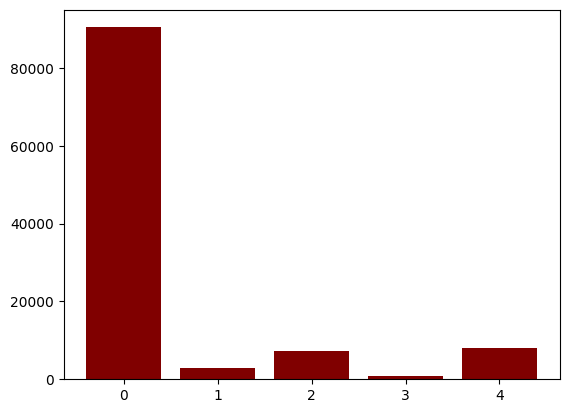

In [43]:
# per class data status plotting,
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

<Axes: xlabel='300'>

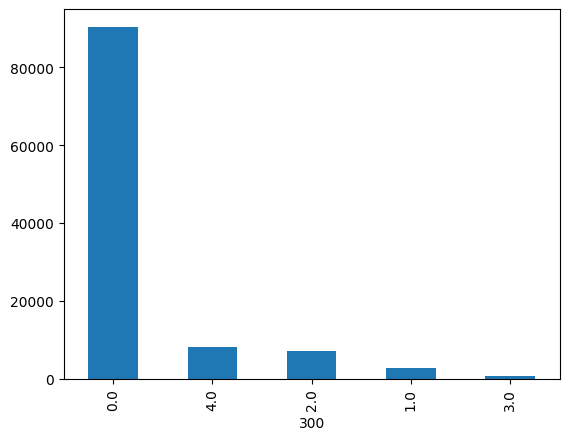

In [44]:
# shortcut for per class data status plotting,
# Order is not maintained by class. Higher to lower
df_ecg[300].value_counts().plot(kind='bar')

## **D2: Train-Test Spliting**
**Note: Class Balance should be done on Training Data Only. Not Testing Data.**

In [86]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

In [87]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [47]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [48]:
# saving the test data (in imbalanced condition)
file_name = project_path + 'test_data.pkl'
test_data.to_pickle(file_name)

**Training dataset status checking:** balanced / imbalanced

300
0.0    72396
4.0     6421
2.0     5773
1.0     2223
3.0      631
Name: count, dtype: int64


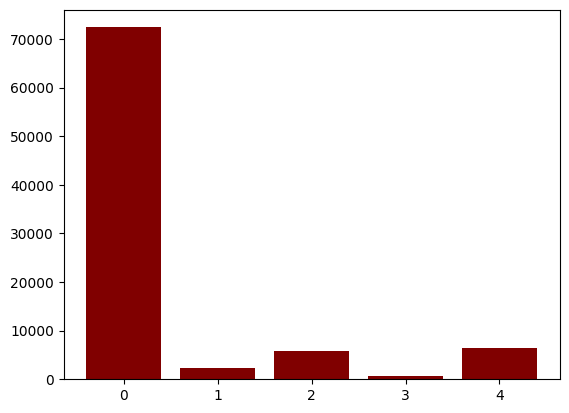

In [49]:
# Imblanced training data graph ploting
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

## **D3: Class balancing by undersampling and SMOTE**
**SMOTE** stands for '**Synthetic Minority Oversampling Technique**'.
Plan for train data
1. Class 1: Randomly selected 50000 data
2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

In [50]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [51]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [52]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [54]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-0.28722445, -0.28848494, -0.28968116, ..., -0.2676001 ,
        -0.27120236,  0.        ],
       [-0.30751179, -0.3057489 , -0.30397116, ...,  0.75158413,
         0.82591842,  0.        ],
       [-0.16800687, -0.17244045, -0.17732933, ..., -0.28988055,
        -0.28821461,  1.        ],
       ...,
       [-0.07768788, -0.0759095 , -0.07457754, ..., -0.13804258,
        -0.13573806,  0.        ],
       [-0.65170895, -0.66662218, -0.68198135, ..., -0.11181153,
        -0.0988044 ,  2.        ],
       [ 0.0824179 ,  0.05861659,  0.0314233 , ...,  1.74909868,
         1.61083942,  2.        ]], shape=(250000, 301))

300
0.0    50000
1.0    50000
2.0    50000
3.0    50000
4.0    50000
Name: count, dtype: int64


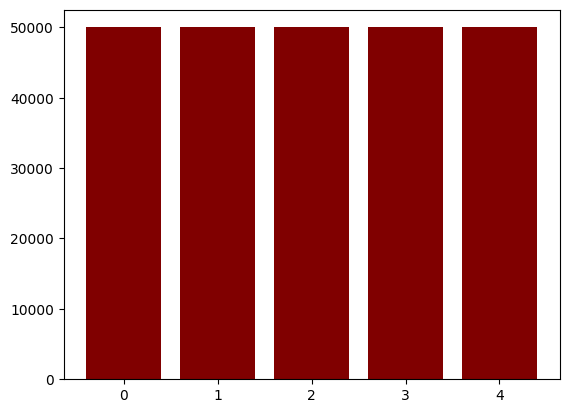

In [55]:
# blanced training data graph ploting
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
file_name = project_path + 'train_data_SMOTE.pkl'
train_data_r.to_pickle(file_name)

In [56]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

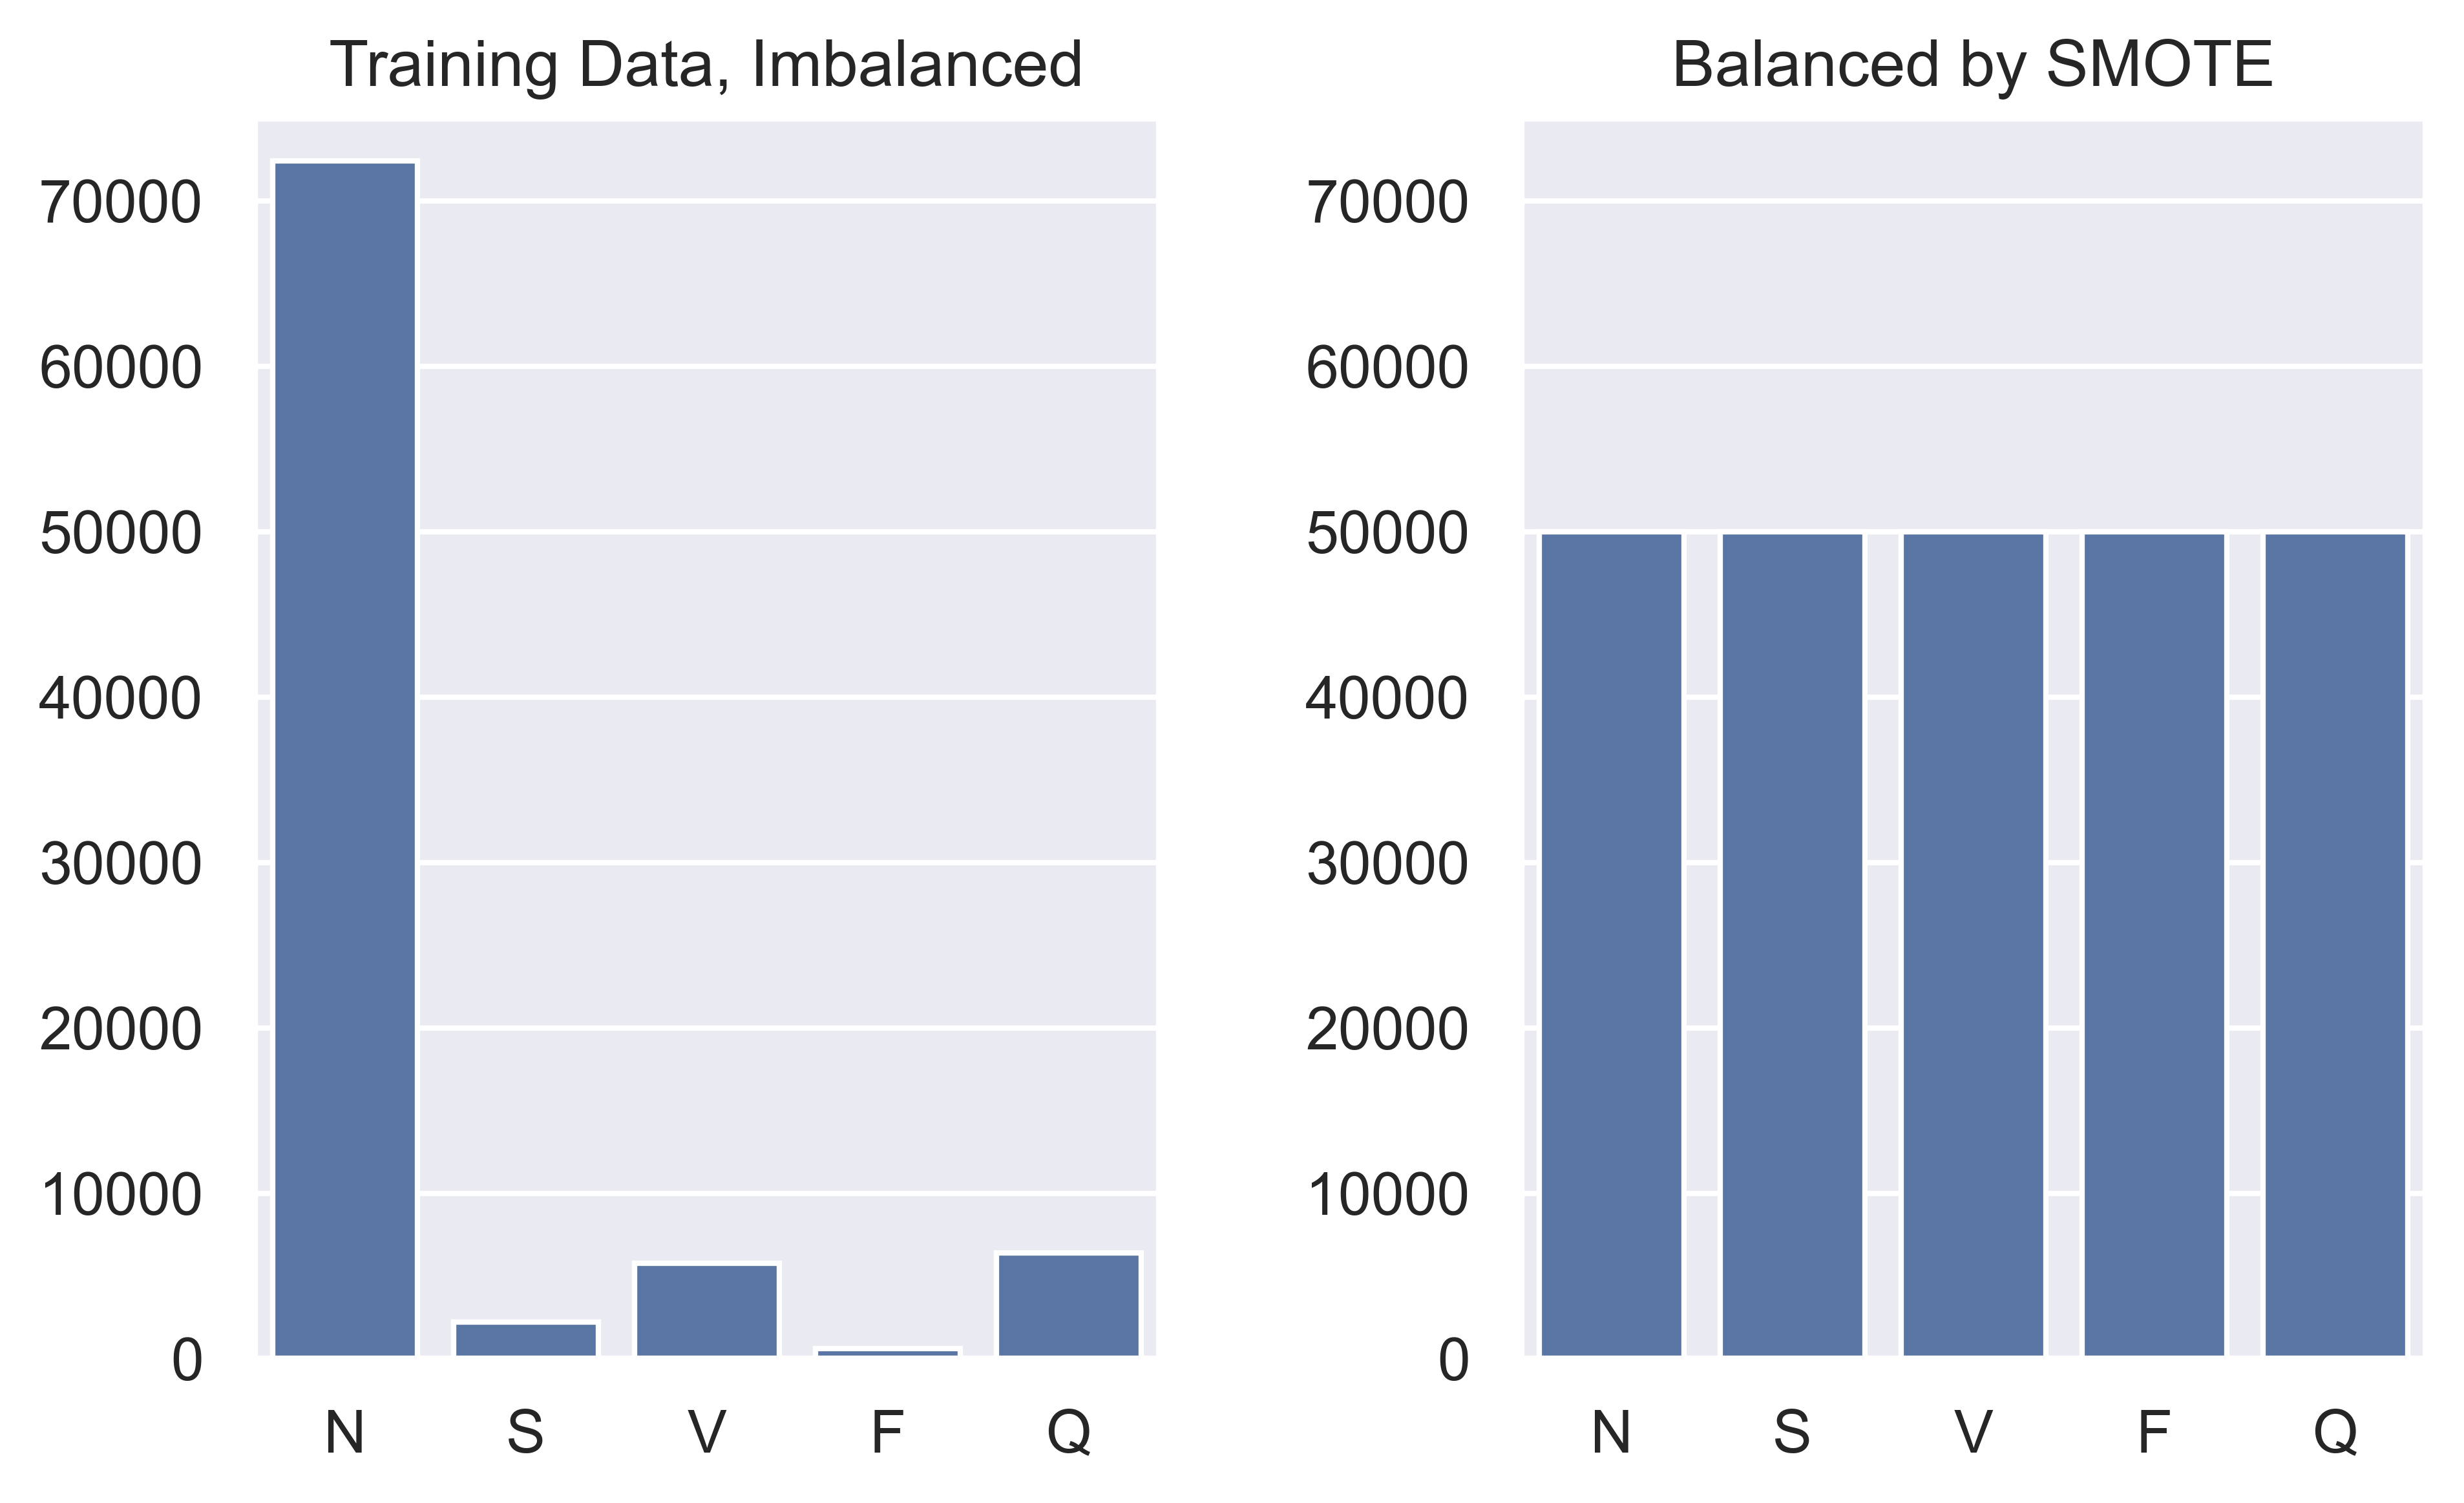

In [57]:
# a single plot which gives proper illustration before and after class balancing
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = [72420, 2212, 5774, 637, 6401])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = class_data.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
fig.savefig(figure_path+ 'Class balancing.png')

# **Part E: Model Building and Training**
A **CNN-LSTM and attention** based hybrid model is formulated.

## **E1: Attention Mechanism**
**Convolutional Block Attention Module** ([CBAM](https://arxiv.org/abs/1807.06521)) consists two parts (i) **channel attention**, (ii) spatial attention. ECG is an 1D signal and 1-lead ECG is used in the modle.Therefore, only channel attention is only used.

In [58]:
# udf for channel attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [59]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

## **E2: CNN-LSTM and attention model architecture**

### **a. Model building**

In [60]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, sixteen 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(16, 8),
        # SpatialAttention(7),
        # The first pooling layer, max pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The second convolution layer, 32 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(32, 8),
        # SpatialAttention(7),
        # The second pooling layer, max pooling, 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The third convolution layer, 64 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(64, 8),
        # SpatialAttention(7),
        # The third pooling layer, average pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # The fourth convolution layer, 128 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(128, 8),
        SpatialAttention(7),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 32 nodes
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

### **b. Hyperparameter Tuning**
Many architectures of model is found by changing hyperparameters.
* Model: with or without channel or spatial attention.
* CNN Filters: Number of filters in each Conv layer is changing like 4, 16, 32, 64, 128 etc.
* LSTM Units: Number of units of two LSTM layer is varing like 32, 64, 128 etc.

In [61]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, four 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu'),
        # The first pooling layer, max pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The second convolution layer, 16 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu'),
        # The second pooling layer, max pooling, four 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The third convolution layer, 32 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu'),
        # The third pooling layer, average pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),
        # The fourth convolution layer, 64 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu'),
        # LSTM layer, 128 nodes
        tf.keras.layers.LSTM(128, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

### **c. Model Training**

**Build, save and then Fit the Model.**
If we have already the saved model, then no need to build, save and fit again.

In [62]:
#Define the log directory, which must be a subdirectory of the specified
#directory when starting the web application. It is recommended to use date and time as the subdirectory name
logdir = project_path + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "ecg_model_code 17_t5.h5"

In [63]:
# percentage of training data used for model validation
ratio = 0.2

In [64]:
if os.path.exists(model_path):
  # Import the trained model
  print('Model is already have in the filepath')
  model = tf.keras.models.load_model(filepath=model_path)
else:
  # Build a CNN model
  print('Model not found, now building and then saving')
  # Use the buildModel function with attention layers from cell A652FHVOOKF5
  model = buildModel()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  # Define the TensorBoard object
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
  # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
  checkpoint_filepath=project_path + "code_17_t5_weights.weights.h5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                 save_weights_only=True, monitor='val_accuracy',
                                                                 mode='max', save_best_only=True)
  callback_list = [tensorboard_callback, model_checkpoint_callback]
  # Training and Validation
  history = model.fit(x_train, y_train, epochs=30,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
  model.save(filepath=model_path)

Model is already have in the filepath


### **d. Plotting Accuracy and Loss**
Training and Validation accuray and loss curve plotting.

In [ ]:
# plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss') # label is actually 'validation accuracy'
plt.legend()
plt.show()

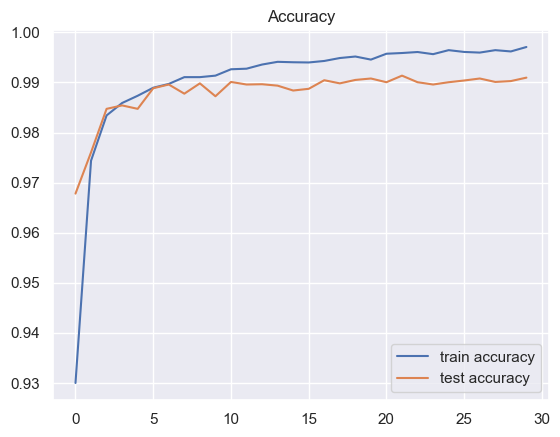

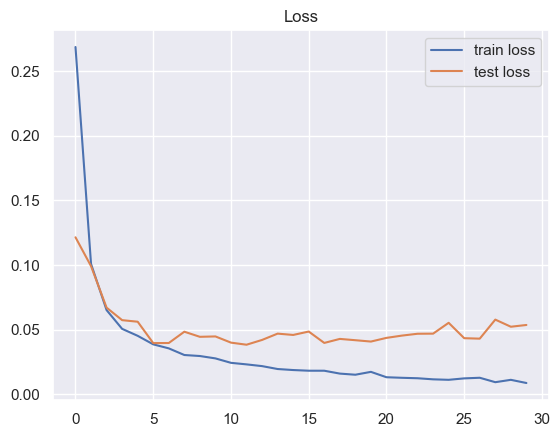

# **Part F: Results**


## **F1: Classification Accuracy and Confusion Matrix**
The overall classification accuracy and confusion matrix generated by the follwoing code.

**Model Testing**
* a. Using **recently trained** and Saved Model after 30 Epochs.
* b. Using the **best model** saved by *'model checkpoint'* callback.

**a. Using Recently Trained Model**

In [66]:
# evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 99.61, Test Accuracy: 99.05
Training Loss: 1.64, Test Loss: 4.94


**b. Using the Best Model**
We saved many checkpoints of the model. Among these checkpoints we will consider the checkpoint which has the largest validation accuracy. Then copy its path and update the model weights.

In [ ]:
# model2 taken fro model_checkpoint callback
model2 = buildModel()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Update the weights with best validation accuracy # Loads the weights
model2.load_weights(checkpoint_filepath)

c:\Desktop Folders\af\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Desktop Folders\af\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# evaluate the best model
train_loss_cp, train_acc_cp = model2.evaluate(x_train, y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc_cp*100, test_acc_cp*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss_cp*100, test_loss_cp*100))

Training Accuracy: 99.53, Test Accuracy: 99.08
Training Loss: 1.70, Test Loss: 4.43


**Confusion Matrix**

In [ ]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step


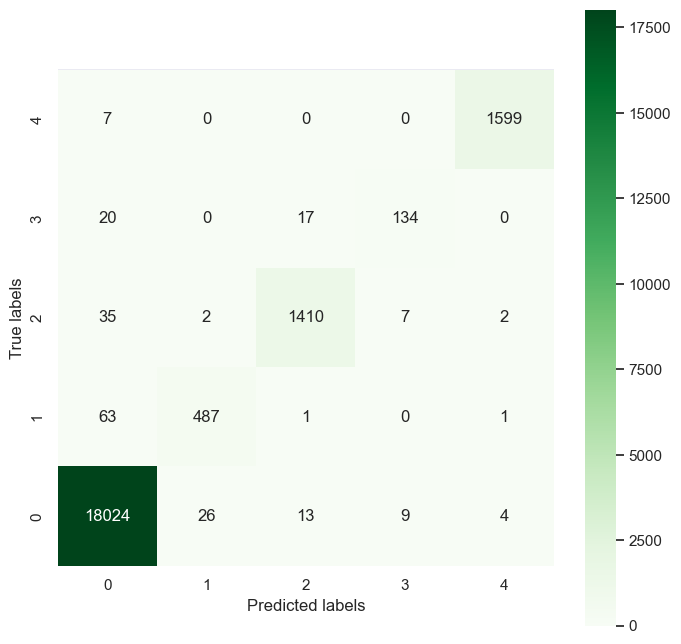

In [ ]:
# predict
y_pred = np.argmax(model.predict(x_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(y_test, y_pred)

## **F2: Per Class Performance**
Calculating per class Sensitivity, Specificity, Accuracy and F1 score.

In [67]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame

    Return:
        report (dict)
    """

    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix

    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report

**a. Recently Trained Model**

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
y_pred = np.argmax(model.predict(x_test), axis=-1)
multi_classification_report(y_test, y_pred, labels=labels, encoded_labels=True, as_frame=True)

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>N</th>
      <th>S</th>
      <th>V</th>
      <th>F</th>
      <th>Q</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Sensitivity (%)</th>
      <td>99.712326</td>
      <td>88.224638</td>
      <td>96.840659</td>
      <td>78.362573</td>
      <td>99.564134</td>
    </tr>
    <tr>
      <th>Specificity (%)</th>
      <td>96.697490</td>
      <td>99.868600</td>
      <td>99.848076</td>
      <td>99.926233</td>
      <td>99.965441</td>
    </tr>
    <tr>
      <th>F1 Score (%)</th>
      <td>99.511387</td>
      <td>91.283974</td>
      <td>97.342078</td>
      <td>83.489097</td>
      <td>99.564134</td>
    </tr>
    <tr>
      <th>Per Class Accuracy (%)</th>
      <td>99.190339</td>
      <td>99.574585</td>
      <td>99.647775</td>
      <td>99.757559</td>
      <td>99.935959</td>
    </tr>
  </tbody>
</table>
</div>

**b. Best Model**

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
y_pred = np.argmax(model.predict(x_test), axis=-1)
multi_classification_report(y_test, y_pred, labels=labels, encoded_labels=True, as_frame=True)

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>N</th>
      <th>S</th>
      <th>V</th>
      <th>F</th>
      <th>Q</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Sensitivity (%)</th>
      <td>99.712326</td>
      <td>87.137681</td>
      <td>97.458791</td>
      <td>78.947368</td>
      <td>99.626401</td>
    </tr>
    <tr>
      <th>Specificity (%)</th>
      <td>96.803170</td>
      <td>99.877986</td>
      <td>99.808870</td>
      <td>99.930844</td>
      <td>99.995063</td>
    </tr>
    <tr>
      <th>F1 Score (%)</th>
      <td>99.522377</td>
      <td>90.840415</td>
      <td>97.391901</td>
      <td>84.112150</td>
      <td>99.781727</td>
    </tr>
    <tr>
      <th>Per Class Accuracy (%)</th>
      <td>99.208636</td>
      <td>99.556287</td>
      <td>99.652349</td>
      <td>99.766708</td>
      <td>99.967980</td>
    </tr>
  </tbody>
</table>
</div>

In [75]:
%pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ----------- --------------------------- 81.9/275.7 kB 2.2 MB/s eta 0:00:01
     ------------------------- ------------ 184.3/275.7 kB 2.8 MB/s eta 0:00:01
     ------------------------------------ - 266.2/275.7 kB 2.3 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.9 MB 2.6 MB/s eta 0:00:06
    --------------------------------------- 0.2/12.9 MB 2.7 MB/s eta 0:00:05
   - -------------------------------------- 0.4/12.9 MB 2.8 MB/s eta 0:00:05
   - -------------------------------------- 0.4/12.9 MB 2.6 MB/s eta 0:00:05
   - -------------------------------------- 0.4/12.9 MB 2.6 MB/s eta 0:00:05
   - -------------------------------------- 0.6/12


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from lime.lime_tabular import LimeTabularExplainer # Import necessary library here

# --- 1. DATA SETUP & RESHAPING ---

# Defensive check to ensure data is 3D (N, 300, 1)
def ensure_3d(arr):
    arr = np.asarray(arr, dtype=np.float32)
    if arr.ndim == 2:
        return arr[..., np.newaxis]
    elif arr.ndim == 3 and arr.shape[2] == 1:
        return arr
    raise ValueError(f'Input data shape {arr.shape} is unexpected.')

# Assumes x_train and x_test are loaded upstream
try:
    x_train = ensure_3d(x_train)
    x_test = ensure_3d(x_test)
except NameError:
    print("Error: x_train or x_test is not defined. Please run data loading cells first.")
except ValueError as e:
    print(f"Error during reshaping: {e}")

# Define global class names
class_names = ['N', 'S', 'V', 'F', 'Q']

# Define fixed random state for reproducibility
rng = np.random.default_rng(42)

# Define background data (100 samples from training)
bg_size = 100
bg_idx = rng.choice(x_train.shape[0], size=bg_size, replace=False)
background = x_train[bg_idx]

# Define test subset (5 samples)
N_SAMPLES = 5
test_idx = rng.choice(x_test.shape[0], size=N_SAMPLES, replace=False)
X_test_sub = x_test[test_idx]
y_test_sub = y_test[test_idx]

# Extract single sample for explanation (index 0 of the subset)
sample_index = 0
X_test_sample = X_test_sub[sample_index]
X_test_sample_2d = X_test_sample.reshape(-1) # 1D array for LIME input

print(f"Data setup complete. Background shape: {background.shape}, Sample shape: {X_test_sample.shape}")

In [ ]:
# --- 2. STATIC PREDICTION FUNCTIONS (The Fix for Instability) ---

# 1. Define the Global Static Prediction Function
# Enforces shape=[None, 300, 1] to solve the ValueError.
@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, 300, 1], dtype=tf.float32)
])
def predict_static_graph(X_input):
    """Enforces a static input shape/rank on the execution graph."""
    # This assumes 'model' is defined and trained globally
    return model(X_input, training=False) 

# 2. The LIME Adapter Wrapper (Handles all LIME input shapes)
def predict_proba_for_xai_final(X_in):
    """
    Adapter function for LIME. It ensures the data is correctly shaped and 
    calls the stable static graph prediction function.
    """
    X = np.asarray(X_in, dtype=np.float32)
    
    # Case A: Single Sample Input (300, 1) - from X_test_sample visualization call
    if X.ndim == 2 and X.shape == (300, 1):
        # Fix: Prepend the Batch dimension to get (1, 300, 1).
        X_fixed = X[np.newaxis, :, :] 
        
    # Case B: Standard LIME Batch Sampled Input (N_samples, 300)
    elif X.ndim == 2 and X.shape[1] == 300:
        # Standard multi-sample batch. Add channel dimension to get (N, 300, 1).
        X_fixed = X[:, :, np.newaxis] 
        
    # Case C: Already 3D (N, 300, 1). Perfect.
    elif X.ndim == 3 and X.shape[1] == 300 and X.shape[2] == 1:
        X_fixed = X
        
    else:
        # Catch unexpected shapes.
        raise ValueError(f"LIME Input has unexpected shape: {X.shape}. Cannot fix.")

    # 3. Use the stable static graph prediction
    return predict_static_graph(X_fixed).numpy()

Initializing LIME Explainer...
Generating LIME explanation for sample 0...

--- LIME Explanation Report for Sample ---
Model Prediction: N (Confidence: 1.00)
----------------------------------------
✅ Features that SUPPORTED 'N':
   The model was influenced by amplitudes around time steps: [100, 101, 102, 127]...
   (Total 4 positive steps found)

❌ Features that OPPOSED 'N':
   Amplitudes around time steps: [16, 85, 87, 88, 89] pushed the prediction AWAY.
   (Total 16 negative steps found)
----------------------------------------
🔍 ECG Interpretation:
   The most influential features are clustered across time steps t_100-t_91.


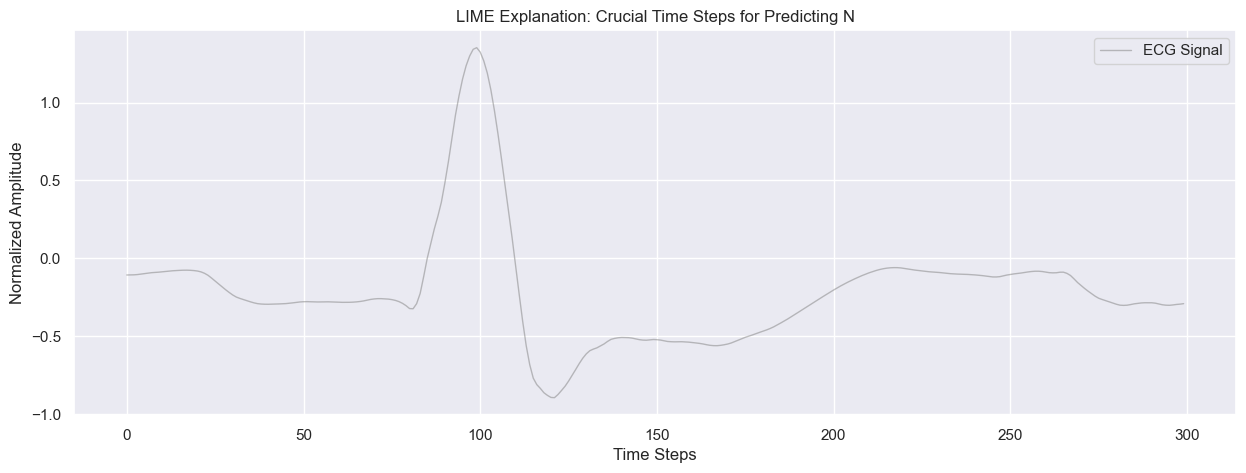

In [125]:
# --- 3. LIME EXECUTION, REPORTING, AND VISUALIZATION ---

# Define the plot function (includes the IndexError fix)
def plot_ecg_lime(signal, explanation, predicted_index, class_names):
    exp_list = explanation.as_list(label=predicted_index)
    sig_flattened = signal.flatten()
    sig_len = len(sig_flattened)
    
    plt.figure(figsize=(15, 5))
    plt.plot(sig_flattened, color='grey', linewidth=1, alpha=0.5, label='ECG Signal')
    
    for feature_index, weight in exp_list:
        try:
            # Cast index to integer and clamp within bounds (0 to 299)
            index = int(feature_index)
            index = max(0, min(index, sig_len - 1)) 
        except ValueError:
            continue 
        
        color = 'red' if weight > 0 else 'blue'
        alpha = min(0.8, abs(weight) * 3)
        
        plt.axvline(x=index, color=color, alpha=alpha, linestyle='--')
        plt.scatter(index, sig_flattened[index], s=50, color=color, zorder=10)

    predicted_class = class_names[predicted_index]
    plt.title(f"LIME Explanation: Crucial Time Steps for Predicting {predicted_class}")
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.show()

# Define the report function (solves the KeyError)
def generate_lime_report(explanation, predicted_index, confidence, class_names):
    exp_list = explanation.as_list(label=predicted_index)
    predicted_class = class_names[predicted_index]

    positive_features = []
    negative_features = []
    
    for feature_name, weight in exp_list:
        time_step = int(feature_name.split('_')[1])
        if weight > 0:
            positive_features.append((time_step, weight))
        else:
            negative_features.append((time_step, weight))

    report = []
    report.append(f"--- LIME Explanation Report for Sample ---")
    report.append(f"Model Prediction: {predicted_class} (Confidence: {confidence:.2f})")
    report.append("-" * 40)
    
    if positive_features:
        pos_steps = sorted([f[0] for f in positive_features])
        report.append(f"✅ Features that SUPPORTED '{predicted_class}':")
        report.append(f"   The model was influenced by amplitudes around time steps: {pos_steps[:5]}...")
        report.append(f"   (Total {len(positive_features)} positive steps found)")
    
    if negative_features:
        neg_steps = sorted([f[0] for f in negative_features])
        report.append(f"\n❌ Features that OPPOSED '{predicted_class}':")
        report.append(f"   Amplitudes around time steps: {neg_steps[:5]} pushed the prediction AWAY.")
        report.append(f"   (Total {len(negative_features)} negative steps found)")

    report.append("-" * 40)
    all_steps = sorted([f[0] for f in exp_list])
    if all_steps:
        report.append(f"🔍 ECG Interpretation:")
        report.append(f"   The most influential features are clustered across time steps {min(all_steps)}-{max(all_steps)}.")

    return "\n".join(report)

# --- EXECUTION ---

# LIME Explainer Initialization
print("Initializing LIME Explainer...")
background_2d = background.reshape(background.shape[0], -1)
explainer = LimeTabularExplainer(
    training_data=background_2d,
    feature_names=[f't_{i}' for i in range(300)],
    class_names=class_names,
    mode='classification',
    discretize_continuous=False, 
    random_state=42
)

# 3. Get the explanation
print(f"Generating LIME explanation for sample {sample_index}...")
explanation = explainer.explain_instance(
    data_row=X_test_sample_2d,      
    predict_fn=predict_proba_for_xai_final,
    num_features=20,
    labels=np.arange(len(class_names))
)

# 4. Final Output and Visualization
pred_probs = predict_proba_for_xai_final(X_test_sample) 
pred_idx = np.argmax(pred_probs)
confidence = pred_probs.max()

# Print the report
report_text = generate_lime_report(explanation, pred_idx, confidence, class_names)
print("\n" + report_text)

# Run the LIME visualization
plot_ecg_lime(X_test_sample, explanation, pred_idx, class_names)

In [133]:
import numpy as np
import random
import tensorflow as tf

# --- 1. SAFELY REDEFINE THE TEST SUBSET (N=50) ---

# Define global class names (Ensuring it's available for the report)
class_names = ['N', 'S', 'V', 'F', 'Q']

# Increase subset size to 50 to improve the chance of finding an arrhythmia
N_SAMPLES_NEW = 50 

# Define fixed random state for reproducibility
rng = np.random.default_rng(42)

# Select 50 random indices from the full x_test
new_test_idx = rng.choice(x_test.shape[0], size=N_SAMPLES_NEW, replace=False)

# Redefine the subset variables using the larger sample size
X_test_sub = x_test[new_test_idx]
y_test_sub = y_test[new_test_idx]

# --- 2. RERUN DIAGNOSTIC CHECK ---

# Use the stable prediction function (predict_proba_for_xai_final should be in memory)
predictions = predict_proba_for_xai_final(X_test_sub)
pred_indices = np.argmax(predictions, axis=1)
true_indices = np.argmax(y_test_sub, axis=1) if y_test_sub.ndim > 1 else y_test_sub

print("--- NEW SUBSET PREDICTION CHECK (N=50) ---")
print("Look for the first index 'i' where Arrhythmia? is True.")
arrhythmia_found = False

for i in range(len(X_test_sub)):
    true_class = class_names[true_indices[i]]
    pred_class = class_names[pred_indices[i]]
    
    # Arrhythmia classes are S, V, F, Q (indices 1, 2, 3, 4)
    is_arrhythmic = pred_indices[i] != 0
    
    print(f"Sample {i}: True={true_class}, Predicted={pred_class} (Arrhythmia? {is_arrhythmic})")
    
    if is_arrhythmic and not arrhythmia_found:
        print(f"SUCCESS: Found arrhythmia at index {i}. Use this index!")
        arrhythmia_found = True

print("-----------------------------------------")

--- NEW SUBSET PREDICTION CHECK (N=50) ---
Look for the first index 'i' where Arrhythmia? is True.
Sample 0: True=N, Predicted=N (Arrhythmia? False)
Sample 1: True=N, Predicted=N (Arrhythmia? False)
Sample 2: True=N, Predicted=N (Arrhythmia? False)
Sample 3: True=N, Predicted=N (Arrhythmia? False)
Sample 4: True=N, Predicted=N (Arrhythmia? False)
Sample 5: True=N, Predicted=N (Arrhythmia? False)
Sample 6: True=N, Predicted=N (Arrhythmia? False)
Sample 7: True=N, Predicted=V (Arrhythmia? True)
SUCCESS: Found arrhythmia at index 7. Use this index!
Sample 8: True=N, Predicted=N (Arrhythmia? False)
Sample 9: True=N, Predicted=N (Arrhythmia? False)
Sample 10: True=N, Predicted=N (Arrhythmia? False)
Sample 11: True=N, Predicted=N (Arrhythmia? False)
Sample 12: True=N, Predicted=N (Arrhythmia? False)
Sample 13: True=N, Predicted=N (Arrhythmia? False)
Sample 14: True=N, Predicted=N (Arrhythmia? False)
Sample 15: True=N, Predicted=N (Arrhythmia? False)
Sample 16: True=N, Predicted=Q (Arrhythmia

Generating LIME explanation for sample 7...

Model predicted: V (Confidence: 1.00)

--- LIME Explanation Report for Sample ---
Model Prediction: V (Confidence: 1.00)
----------------------------------------
✅ Features that SUPPORTED 'V':
   The model was influenced by amplitudes around time steps: [134, 190, 192, 196, 198]...
   (Total 15 positive steps found)

❌ Features that OPPOSED 'V':
   Amplitudes around time steps: [98, 99, 100, 101, 156] pushed the prediction AWAY.
   (Total 5 negative steps found)
----------------------------------------
🔍 ECG Interpretation:
   The most influential features are clustered across time steps t_100-t_99.


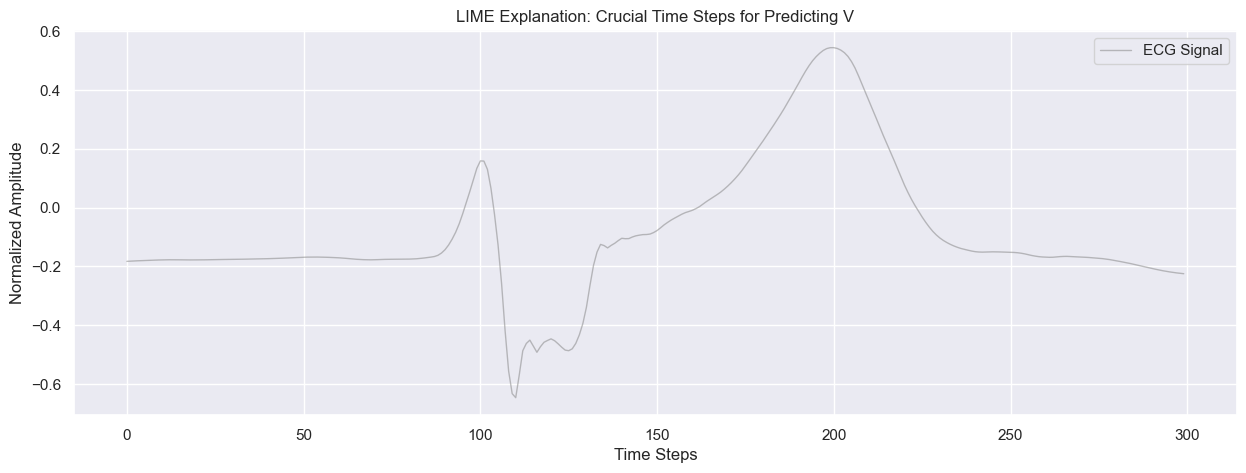

In [130]:
# --- LIME Execution for Arrhythmia-Positive Sample ---

# 🚨 CHANGE THIS INDEX based on the output of the prediction check above 🚨
sample_index = 7 # EXAMPLE: Change this to the index you want to explain

# Re-extract the sample
X_test_sample = X_test_sub[sample_index]
X_test_sample_2d = X_test_sample.reshape(-1) 

# 3. Get the explanation
print(f"Generating LIME explanation for sample {sample_index}...")
explanation = explainer.explain_instance(
    data_row=X_test_sample_2d,      
    predict_fn=predict_proba_for_xai_final,
    num_features=20,
    labels=np.arange(len(class_names))
)

# 4. Final Output and Visualization
pred_probs = predict_proba_for_xai_final(X_test_sample) 
pred_idx = np.argmax(pred_probs)
confidence = pred_probs.max()
pred_class = class_names[pred_idx]

print(f"\nModel predicted: {pred_class} (Confidence: {confidence:.2f})")

# Print the report
report_text = generate_lime_report(explanation, pred_idx, confidence, class_names)
print("\n" + report_text)

# Run the LIME visualization
plot_ecg_lime(X_test_sample, explanation, pred_idx, class_names)

In [129]:
import numpy as np
import random
import tensorflow as tf

# --- 1. SAFELY REDEFINE THE TEST SUBSET (N=50) ---

# Define global class names (Ensuring it's available for the report)
class_names = ['N', 'S', 'V', 'F', 'Q']

# Increase subset size to 50 to improve the chance of finding an arrhythmia
N_SAMPLES_NEW = 50 

# Define fixed random state for reproducibility
rng = np.random.default_rng(42)

# Select 50 random indices from the full x_test
new_test_idx = rng.choice(x_test.shape[0], size=N_SAMPLES_NEW, replace=False)

# Redefine the subset variables using the larger sample size
X_test_sub = x_test[new_test_idx]
y_test_sub = y_test[new_test_idx]

# --- 2. RERUN DIAGNOSTIC CHECK ---

# Use the stable prediction function (predict_proba_for_xai_final should be in memory)
predictions = predict_proba_for_xai_final(X_test_sub)
pred_indices = np.argmax(predictions, axis=1)
true_indices = np.argmax(y_test_sub, axis=1) if y_test_sub.ndim > 1 else y_test_sub

print("--- NEW SUBSET PREDICTION CHECK (N=50) ---")
print("Look for the first index 'i' where Arrhythmia? is True.")
arrhythmia_found = False

for i in range(len(X_test_sub)):
    true_class = class_names[true_indices[i]]
    pred_class = class_names[pred_indices[i]]
    
    # Arrhythmia classes are S, V, F, Q (indices 1, 2, 3, 4)
    is_arrhythmic = pred_indices[i] != 0
    
    print(f"Sample {i}: True={true_class}, Predicted={pred_class} (Arrhythmia? {is_arrhythmic})")
    
    if is_arrhythmic and not arrhythmia_found:
        print(f"SUCCESS: Found arrhythmia at index {i}. Use this index!")
        arrhythmia_found = True

print("-----------------------------------------")

--- NEW SUBSET PREDICTION CHECK (N=50) ---
Look for the first index 'i' where Arrhythmia? is True.
Sample 0: True=N, Predicted=N (Arrhythmia? False)
Sample 1: True=N, Predicted=N (Arrhythmia? False)
Sample 2: True=N, Predicted=N (Arrhythmia? False)
Sample 3: True=N, Predicted=N (Arrhythmia? False)
Sample 4: True=N, Predicted=N (Arrhythmia? False)
Sample 5: True=N, Predicted=N (Arrhythmia? False)
Sample 6: True=N, Predicted=N (Arrhythmia? False)
Sample 7: True=N, Predicted=V (Arrhythmia? True)
SUCCESS: Found arrhythmia at index 7. Use this index!
Sample 8: True=N, Predicted=N (Arrhythmia? False)
Sample 9: True=N, Predicted=N (Arrhythmia? False)
Sample 10: True=N, Predicted=N (Arrhythmia? False)
Sample 11: True=N, Predicted=N (Arrhythmia? False)
Sample 12: True=N, Predicted=N (Arrhythmia? False)
Sample 13: True=N, Predicted=N (Arrhythmia? False)
Sample 14: True=N, Predicted=N (Arrhythmia? False)
Sample 15: True=N, Predicted=N (Arrhythmia? False)
Sample 16: True=N, Predicted=Q (Arrhythmia